
--- 'Category' Değişkeni İçin Örnek Kodlar ---
    Orijinal İsim  Atanan Kod
            Books           0
         Clothing           1
      Electronics           2
   Home & Kitchen           3
Sports & Outdoors           4
(Toplam 6 farklı değer var)

--- 'PaymentMethod' Değişkeni İçin Örnek Kodlar ---
   Orijinal İsim  Atanan Kod
      Amazon Pay           0
Cash on Delivery           1
     Credit Card           2
      Debit Card           3
     Net Banking           4
(Toplam 6 farklı değer var)

--- 'State' Değişkeni İçin Örnek Kodlar ---
Orijinal İsim  Atanan Kod
           AZ           0
           CA           1
           CO           2
           DC           3
           FL           4
(Toplam 13 farklı değer var)

--- 'Brand' Değişkeni İçin Örnek Kodlar ---
Orijinal İsim  Atanan Kod
         Apex           0
    BrightLux           1
     CoreTech           2
      FitLife           3
     HomeEase           4
(Toplam 10 farklı değer var)

--- 'City' Değişkeni İçin Ör

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-2019968565.py:86: FutureWarnin

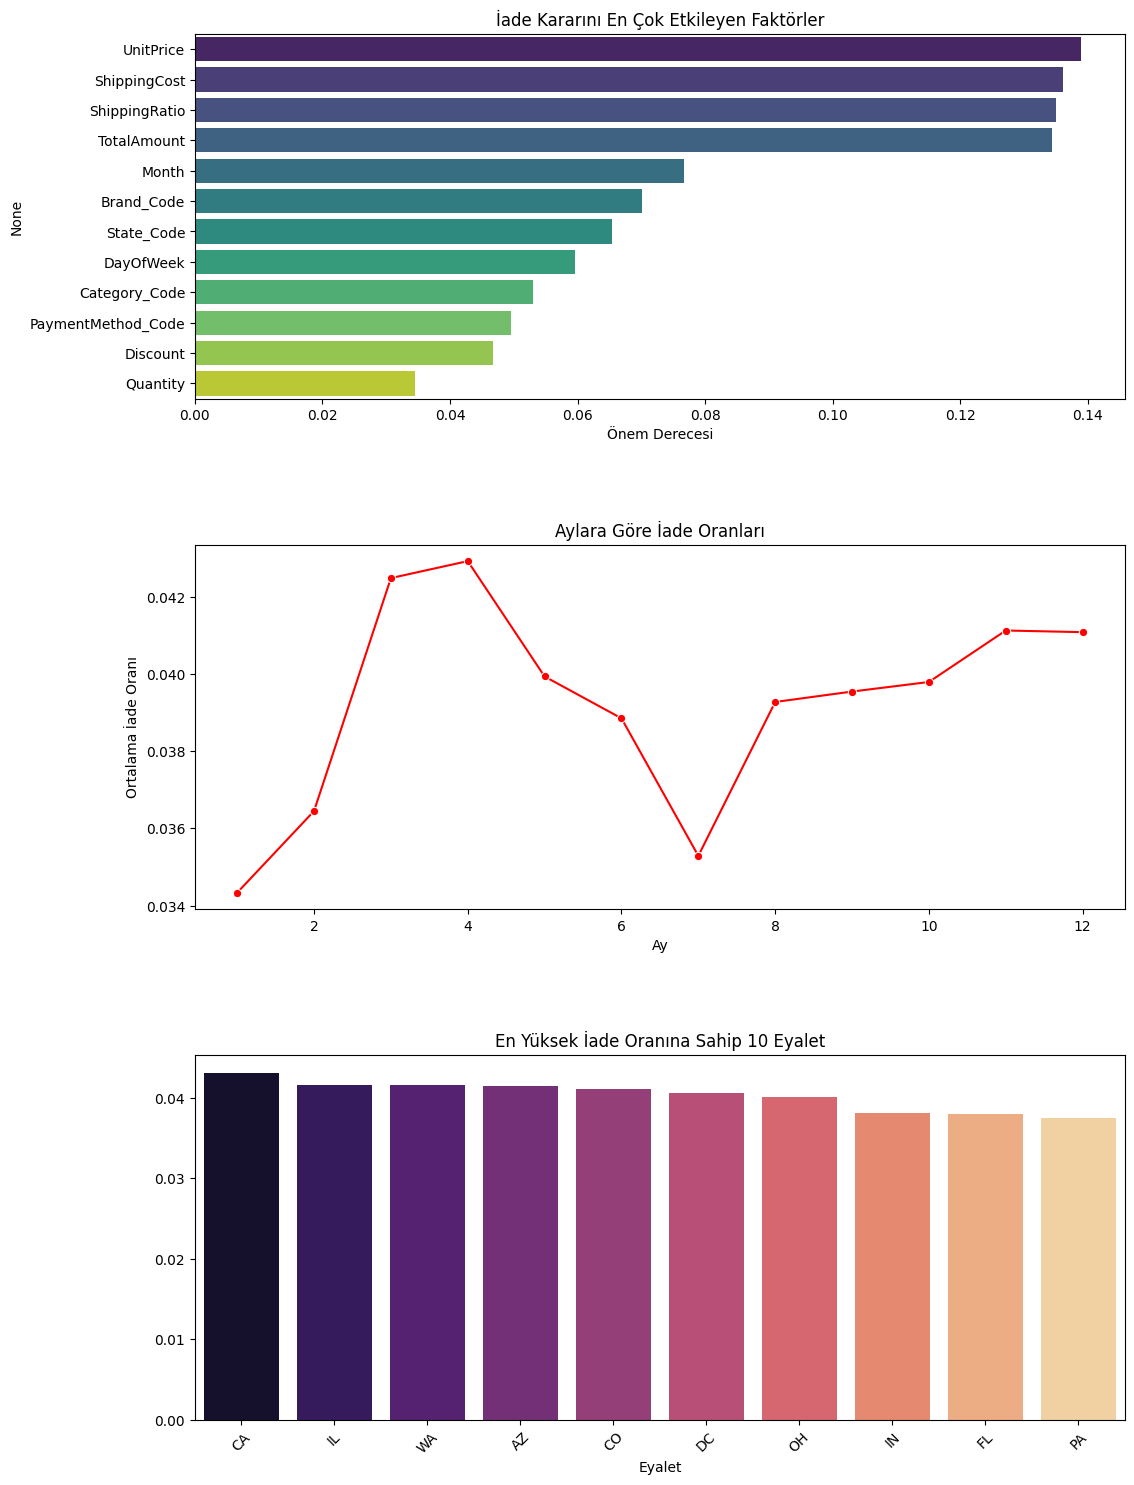

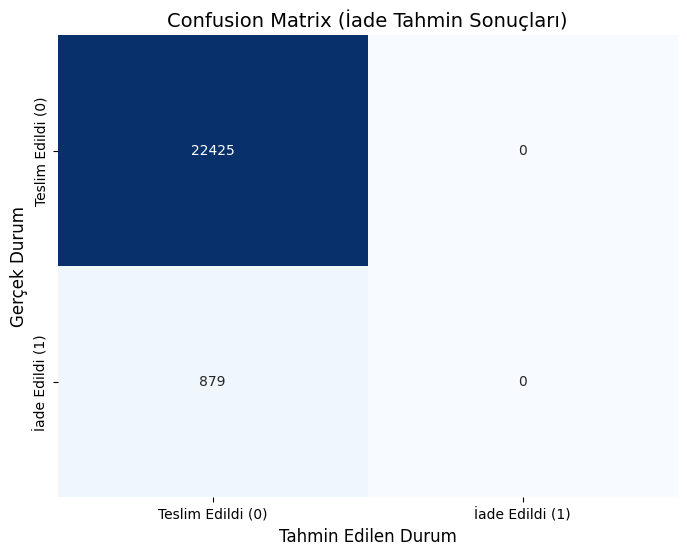

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# 1. VERİ YÜKLEME VE ÖN İŞLEME
# ---------------------------------------------------------
# Veri setini yükle
df = pd.read_csv('/content/drive/MyDrive/Amazon.csv')

# Analiz için sadece 'Delivered' (Başarılı) ve 'Returned' (İade) siparişleri alıyoruz
df_model = df[df['OrderStatus'].isin(['Delivered', 'Returned'])].copy()

# Hedef değişkeni oluştur (1: İade, 0: Teslim Edildi)
df_model['IsReturned'] = df_model['OrderStatus'].apply(lambda x: 1 if x == 'Returned' else 0)

# Tarih verisini ayrıştır
df_model['OrderDate'] = pd.to_datetime(df_model['OrderDate'])
df_model['Month'] = df_model['OrderDate'].dt.month
df_model['DayOfWeek'] = df_model['OrderDate'].dt.dayofweek

# Yeni Özellik Türetme: Kargo Maliyetinin Toplam Tutara Oranı
# (Makaledeki gibi veri setini zenginleştiriyoruz)
df_model['ShippingRatio'] = df_model['ShippingCost'] / df_model['TotalAmount']
df_model['ShippingRatio'] = df_model['ShippingRatio'].fillna(0)

# Kategorik verileri sayısal kodlara dönüştür (Label Encoding)
le = LabelEncoder()
cat_columns = ['Category', 'PaymentMethod', 'State', 'Brand', 'City']
for col in cat_columns:
    df_model[col + '_Code'] = le.fit_transform(df_model[col].astype(str))
    mapping_df = pd.DataFrame({
            'Orijinal İsim': le.classes_,
            'Atanan Kod': range(len(le.classes_))
        })

    # 3. Bu tabloyu ekrana yazdır (Çok uzun olmasın diye ilk 5 tanesini gösteriyoruz)
    print(f"\n--- '{col}' Değişkeni İçin Örnek Kodlar ---")
    print(mapping_df.head(5).to_string(index=False)) # İstersen .head(5) kısmını kaldırıp hepsini görebilirsin
    print(f"(Toplam {len(mapping_df)} farklı değer var)")

# ---------------------------------------------------------
# 2. MAKİNE ÖĞRENMESİ MODELİ (RANDOM FOREST)
# ---------------------------------------------------------
# Tahminde kullanılacak özellikler
features = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost', 'TotalAmount',
            'ShippingRatio', 'Month', 'DayOfWeek',
            'Category_Code', 'PaymentMethod_Code', 'State_Code', 'Brand_Code']

X = df_model[features]
y = df_model['IsReturned']

# Veriyi Eğitim (%70) ve Test (%30) olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeli kur ve eğit (Dengesiz veri için class_weight='balanced' eklendi)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = rf_model.predict(X_test)

# ---------------------------------------------------------
# 3. GÖRSELLEŞTİRME VE SONUÇLAR
# ---------------------------------------------------------
# Metin çıktıları
print("--- SONUÇ RAPORU ---")
print(f"Toplam Analiz Edilen Sipariş: {len(df_model)}")
print(f"Genel İade Oranı: %{df_model['IsReturned'].mean()*100:.2f}")
print(f"Model Doğruluk Oranı (Accuracy): %{accuracy_score(y_test, y_pred)*100:.2f}")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Grafikleri çizdir
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
plt.subplots_adjust(hspace=0.4)

# Grafik 1: Özellik Önem Düzeyleri
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=X.columns[indices], ax=axes[0], palette='viridis')
axes[0].set_title('İade Kararını En Çok Etkileyen Faktörler')
axes[0].set_xlabel('Önem Derecesi')

# Grafik 2: Aylık İade Trendi
monthly_data = df_model.groupby('Month')['IsReturned'].mean()
sns.lineplot(x=monthly_data.index, y=monthly_data.values, marker='o', ax=axes[1], color='red')
axes[1].set_title('Aylara Göre İade Oranları')
axes[1].set_xlabel('Ay')
axes[1].set_ylabel('Ortalama İade Oranı')

# Grafik 3: Eyalet Bazlı İadeler (Top 10)
state_data = df_model.groupby('State')['IsReturned'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=state_data.index, y=state_data.values, ax=axes[2], palette='magma')
axes[2].set_title('En Yüksek İade Oranına Sahip 10 Eyalet')
axes[2].set_xlabel('Eyalet')
axes[2].tick_params(axis='x', rotation=45)

plt.show()
# --- CONFUSION MATRIX GÖRSELLEŞTİRME KODU ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# heatmap: Isı haritası
# annot=True: Kutuların içine sayıları yaz
# fmt='d': Sayıları tamsayı (decimal) olarak yaz (bilimsel gösterim yapma)
# cmap='Blues': Renk paleti
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix (İade Tahmin Sonuçları)', fontsize=14)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.xlabel('Tahmin Edilen Durum', fontsize=12)

# Eksen etiketlerini daha anlaşılır yapalım
plt.xticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])
plt.yticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])

plt.show()

Toplam Sipariş Sayısı: 77677
Benzersiz Müşteri Sayısı: 39416
Birden Fazla Sipariş Veren Müşteri Sayısı: 23082
Tekrar Eden Müşterilerin Toplam Sipariş Sayısı: 61343
Tekrar Eden Siparişlerin Oranı: %78.97
En Çok Sipariş Veren Müşteri Kaç Kez Gelmiş: 9

Benzersiz Ürün Sayısı: 50
En Çok Satılan Ürün Adedi: 1636
Ortalama Ürün Başına Sipariş: 1553.54
Orijinal Eğitim Seti Sayıları: {0: 52239, 1: 2134}
Dengelenmiş Eğitim Seti Sayıları: {0: 2134, 1: 2134}
--- SONUÇ RAPORU ---
Toplam Analiz Edilen Sipariş: 77677
Genel İade Oranı: %3.93
Model Doğruluk Oranı (Accuracy): %49.24

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      0.49      0.65     22389
           1       0.04      0.49      0.07       915

    accuracy                           0.49     23304
   macro avg       0.50      0.49      0.36     23304
weighted avg       0.92      0.49      0.63     23304



/tmp/ipython-input-2991286439.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df, palette='viridis')


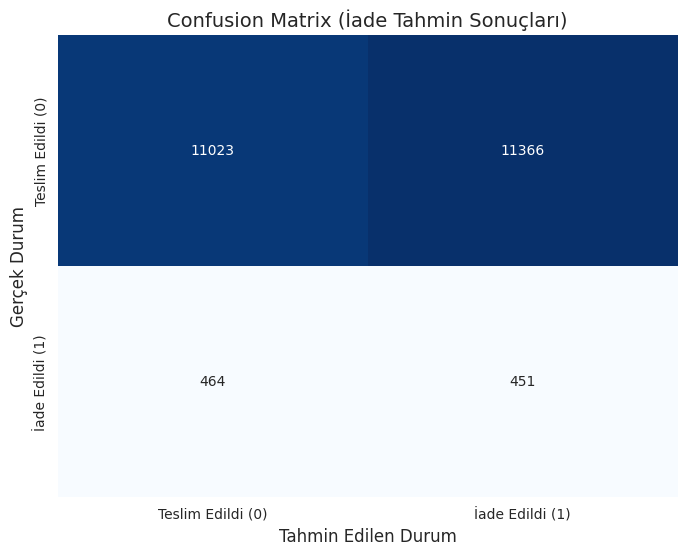

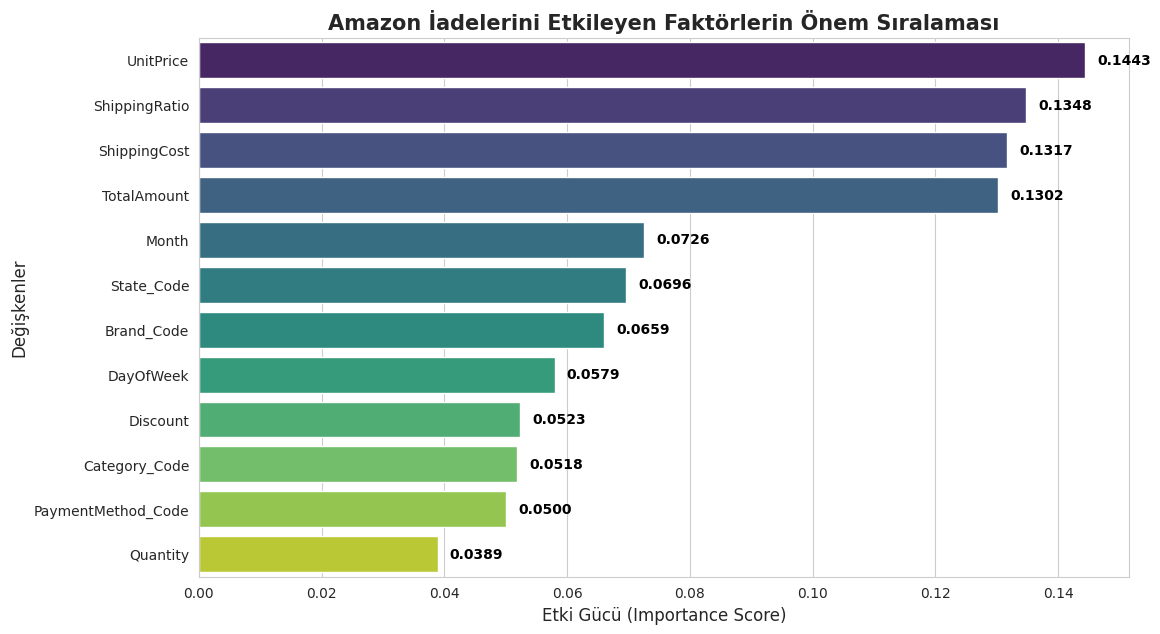

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# ---------------------------------------------------------
# 1. VERİ YÜKLEME VE ÖN İŞLEME
# ---------------------------------------------------------
# Veri setini yükle
df = pd.read_csv('/content/drive/MyDrive/Amazon.csv')

# Analiz için sadece 'Delivered' (Başarılı) ve 'Returned' (İade) siparişleri alıyoruz
df_model = df[df['OrderStatus'].isin(['Delivered', 'Returned'])].copy()

# Müşteri Analizi
total_orders = len(df_model)
unique_customers = df_model['CustomerID'].nunique()
orders_per_customer = df_model['CustomerID'].value_counts()
repeat_customers = orders_per_customer[orders_per_customer > 1]
repeat_customer_count = len(repeat_customers)
repeat_order_count = repeat_customers.sum()

print(f"Toplam Sipariş Sayısı: {total_orders}")
print(f"Benzersiz Müşteri Sayısı: {unique_customers}")
print(f"Birden Fazla Sipariş Veren Müşteri Sayısı: {repeat_customer_count}")
print(f"Tekrar Eden Müşterilerin Toplam Sipariş Sayısı: {repeat_order_count}")
print(f"Tekrar Eden Siparişlerin Oranı: %{repeat_order_count / total_orders * 100:.2f}")
print(f"En Çok Sipariş Veren Müşteri Kaç Kez Gelmiş: {orders_per_customer.max()}")

# Ürün Analizi (Alternatif Strateji İçin)
unique_products = df_model['ProductID'].nunique()
print(f"\nBenzersiz Ürün Sayısı: {unique_products}")
orders_per_product = df_model['ProductID'].value_counts()
print(f"En Çok Satılan Ürün Adedi: {orders_per_product.max()}")
print(f"Ortalama Ürün Başına Sipariş: {orders_per_product.mean():.2f}")

# Hedef değişkeni oluştur (1: İade, 0: Teslim Edildi)
df_model['IsReturned'] = df_model['OrderStatus'].apply(lambda x: 1 if x == 'Returned' else 0)

# Tarih verisini ayrıştır
df_model['OrderDate'] = pd.to_datetime(df_model['OrderDate'])
df_model['Month'] = df_model['OrderDate'].dt.month
df_model['DayOfWeek'] = df_model['OrderDate'].dt.dayofweek

# Yeni Özellik Türetme: Kargo Maliyetinin Toplam Tutara Oranı
# (Makaledeki gibi veri setini zenginleştiriyoruz)
df_model['ShippingRatio'] = df_model['ShippingCost'] / df_model['TotalAmount']
df_model['ShippingRatio'] = df_model['ShippingRatio'].fillna(0)

# Kategorik verileri sayısal kodlara dönüştür (Label Encoding)
le = LabelEncoder()
cat_columns = ['Category', 'PaymentMethod', 'State', 'Brand', 'City']
for col in cat_columns:
    df_model[col + '_Code'] = le.fit_transform(df_model[col].astype(str))

# ---------------------------------------------------------
# 2. MAKİNE ÖĞRENMESİ MODELİ (RANDOM FOREST)
# ---------------------------------------------------------
# Tahminde kullanılacak özellikler
features = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost', 'TotalAmount',
            'ShippingRatio', 'Month', 'DayOfWeek',
            'Category_Code', 'PaymentMethod_Code', 'State_Code', 'Brand_Code']

X = df_model[features]
y = df_model['IsReturned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# RandomUnderSampler tanımla
# sampling_strategy='auto' dersen sayıları 1'e 1 eşitler.
# 0.5 dersen: İadelerin sayısı, Teslim edilenlerin yarısı kadar olsun der (1'e 2 oran).
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Sadece EĞİTİM (Train) setini dengele!
# Test setine asla dokunmuyoruz, o gerçek hayatı temsil etmeli.
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

print(f"Orijinal Eğitim Seti Sayıları: {y_train.value_counts().to_dict()}")
print(f"Dengelenmiş Eğitim Seti Sayıları: {y_train_balanced.value_counts().to_dict()}")

# --- ARTIK MODELİ BU YENİ VERİYLE EĞİT ---
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced) # Dikkat: balanced olanları verdik

# Test verisi üzerinde tahmin yap
y_pred = rf_model.predict(X_test)

# ---------------------------------------------------------
# 3. GÖRSELLEŞTİRME VE SONUÇLAR
# ---------------------------------------------------------
# Metin çıktıları
print("--- SONUÇ RAPORU ---")
print(f"Toplam Analiz Edilen Sipariş: {len(df_model)}")
print(f"Genel İade Oranı: %{df_model['IsReturned'].mean()*100:.2f}")
print(f"Model Doğruluk Oranı (Accuracy): %{accuracy_score(y_test, y_pred)*100:.2f}")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# --- CONFUSION MATRIX GÖRSELLEŞTİRME KODU ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# heatmap: Isı haritası
# annot=True: Kutuların içine sayıları yaz
# fmt='d': Sayıları tamsayı (decimal) olarak yaz (bilimsel gösterim yapma)
# cmap='Blues': Renk paleti
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix (İade Tahmin Sonuçları)', fontsize=14)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.xlabel('Tahmin Edilen Durum', fontsize=12)

# Eksen etiketlerini daha anlaşılır yapalım
plt.xticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])
plt.yticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])

# 3. GÖRSELLEŞTİRME VERİSİNİ HAZIRLAMA
feature_importance_df = pd.DataFrame({
    'Özellik': features,
    'Önem Düzeyi': rf_model.feature_importances_
})
# Büyükten küçüğe sırala
feature_importance_df = feature_importance_df.sort_values(by='Önem Düzeyi', ascending=False)

# 4. GRAFİK ÇİZİMİ
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Yatay Bar Grafiği (Barplot)
ax = sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df, palette='viridis')

# Başlık ve Etiketler
plt.title('Amazon İadelerini Etkileyen Faktörlerin Önem Sıralaması', fontsize=15, fontweight='bold')
plt.xlabel('Etki Gücü (Importance Score)', fontsize=12)
plt.ylabel('Değişkenler', fontsize=12)

# Barların ucuna tam sayısal değerleri yazdır
for i, v in enumerate(feature_importance_df['Önem Düzeyi']):
    ax.text(v + 0.002, i, f"{v:.4f}", color='black', va='center', fontweight='bold')
plt.show()

/tmp/ipython-input-1488874021.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df, palette='viridis')


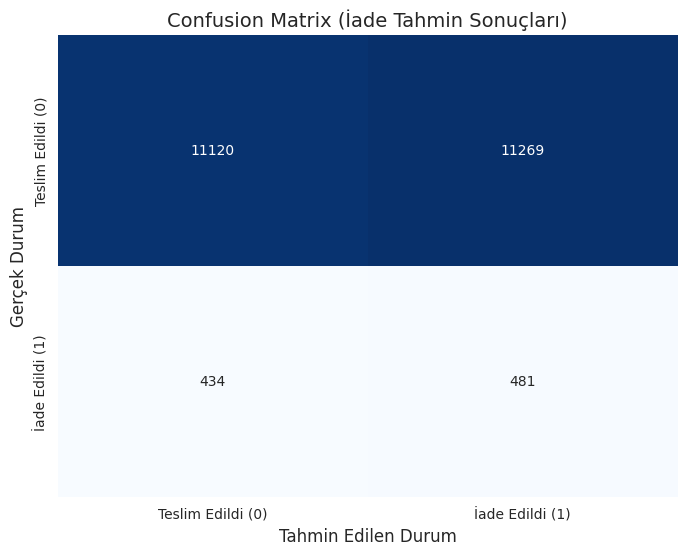

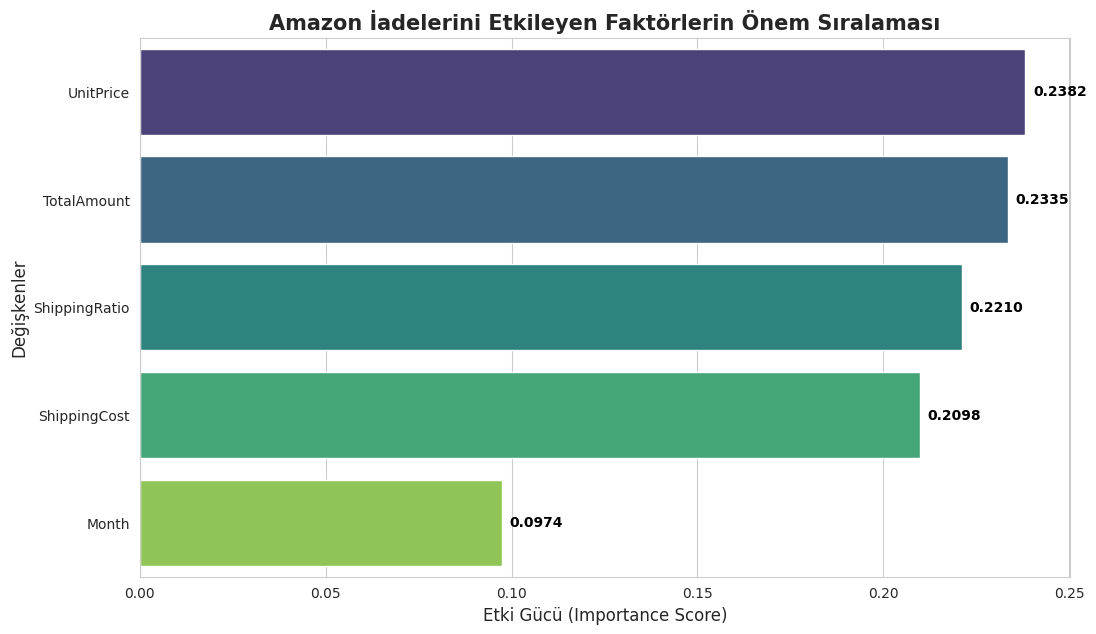

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

# 1. Veri Hazırlığı
df = pd.read_csv('/content/drive/MyDrive/Amazon.csv')
df_model = df[df['OrderStatus'].isin(['Delivered', 'Returned'])].copy()
df_model['IsReturned'] = df_model['OrderStatus'].apply(lambda x: 1 if x == 'Returned' else 0)

# Tarih
df_model['OrderDate'] = pd.to_datetime(df_model['OrderDate'])
df_model['Month'] = df_model['OrderDate'].dt.month
df_model['ShippingRatio'] = df_model['ShippingCost'] / df_model['TotalAmount']
df_model['ShippingRatio'] = df_model['ShippingRatio'].fillna(0)

# TOP 5 Özellik
top_5_features = ['UnitPrice', 'TotalAmount', 'ShippingCost', 'ShippingRatio', 'Month']
X = df_model[top_5_features]
y = df_model['IsReturned']

# Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Dengeleme
train_data = pd.concat([X_train, y_train], axis=1)
returned = train_data[train_data['IsReturned'] == 1]
delivered = train_data[train_data['IsReturned'] == 0]
delivered_downsampled = delivered.sample(n=len(returned), random_state=42)
train_balanced = pd.concat([returned, delivered_downsampled])
X_train_balanced = train_balanced.drop('IsReturned', axis=1)
y_train_balanced = train_balanced['IsReturned']

# Model (XGBoost Mantığı - GradientBoostingClassifier)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Tahmin
y_pred = gb_model.predict(X_test)

# --- CONFUSION MATRIX GÖRSELLEŞTİRME KODU ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# heatmap: Isı haritası
# annot=True: Kutuların içine sayıları yaz
# fmt='d': Sayıları tamsayı (decimal) olarak yaz (bilimsel gösterim yapma)
# cmap='Blues': Renk paleti
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix (İade Tahmin Sonuçları)', fontsize=14)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.xlabel('Tahmin Edilen Durum', fontsize=12)

# Eksen etiketlerini daha anlaşılır yapalım
plt.xticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])
plt.yticks([0.5, 1.5], ['Teslim Edildi (0)', 'İade Edildi (1)'])

# 3. GÖRSELLEŞTİRME VERİSİNİ HAZIRLAMA
feature_importance_df = pd.DataFrame({
    'Özellik': features,
    'Önem Düzeyi': rf_model.feature_importances_
})
# Büyükten küçüğe sırala
feature_importance_df = feature_importance_df.sort_values(by='Önem Düzeyi', ascending=False)

# 4. GRAFİK ÇİZİMİ
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Yatay Bar Grafiği (Barplot)
ax = sns.barplot(x='Önem Düzeyi', y='Özellik', data=feature_importance_df, palette='viridis')

# Başlık ve Etiketler
plt.title('Amazon İadelerini Etkileyen Faktörlerin Önem Sıralaması', fontsize=15, fontweight='bold')
plt.xlabel('Etki Gücü (Importance Score)', fontsize=12)
plt.ylabel('Değişkenler', fontsize=12)

# Barların ucuna tam sayısal değerleri yazdır
for i, v in enumerate(feature_importance_df['Önem Düzeyi']):
    ax.text(v + 0.002, i, f"{v:.4f}", color='black', va='center', fontweight='bold')
plt.savefig('confusion_matrix_visual.png')
plt.show()